<AxesSubplot:xlabel='X', ylabel='y'>

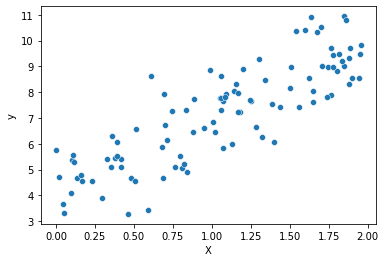

In [12]:
import numpy as np
import seaborn  as sns
import pandas as pd

# Create data set for linear regression
X = 2 * np.random.rand(100,1)
y = 4 + 3 * X + np.random.randn(100,1)
rand_n = pd.DataFrame(np.concatenate((X,y), axis=1), columns=['X','y'])
sns.scatterplot(data=rand_n, x='X', y='y')

In [29]:
# Solve for best thetas
X_b = np.c_[np.ones((100,1)), X]
theta_best = (
    np.linalg
    .inv(X_b.T.dot(X_b))
    .dot(X_b.T).dot(y)
)
theta_best

array([[4.24255545],
       [2.77351253]])

In [32]:
# Make predictions using best theta
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.24255545],
       [9.78958051]])

(0.0, 2.0, 0.0, 15.0)

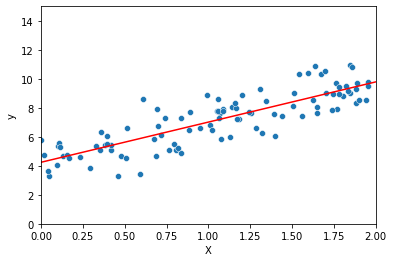

In [40]:
import matplotlib.pyplot as plt
sns.scatterplot(data=rand_n, x='X', y='y')
plt.plot(X_new,y_predict,'r-')
plt.axis([0,2,0,15])

In [35]:
pd.DataFrame(X_new_b)

,0,1
0,1.0,0.0
1,1.0,2.0
